In [1]:
# Import of the needed packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import control as cn

plt.style.use('seaborn-paper')

In [2]:
# Define the functions

# Approximation

# Define the SOTD2FOTD Function
def soptd2foptd(k1,t1,t2,l1):
    # Compute the static gain
    k = k1
    # Compute the additional time delay
    l = l1 + np.min([t1,t2])/2.
    # Compute the lag
    t = np.max([t1,t2]) + np.min([t1,t2])/2.
    return k,t,l

def dt2ptd2foptd(k1,t1,t2,l1,tM):
    # Denominator -> Like SOPTD
    k,t,l = soptd2foptd(k1,t1,t2,l1)
    # Zeros -> Subrtact from lag, but use at least the maximum of t
    t = np.max([t - tM,np.max([t1,t2])])
    return k,t,l

def fotdsum(k1,k2,t1,t2,l1,l2):
    # Get the gain
    k = k1+k2
    # Get the delay (External Time Delay)
    l = np.min([l1,l2]) 
    # Check if the lag is nearly identical
    if np.abs(1.-np.min([t1,t2])/np.max([t1,t2]))>0.98:
        t = np.max([t1,t2])
    else:
        t = np.max([t1,t2]) + np.min([t1,t2])/2.
    # If there is a zero, add zero and distribute lag to delay 
    if (k1*t2+k2*t1)/k < .0:
        l = l  - (k2*t1+k1*t2)/k + np.min([t1,t2])/2.
        
    # If there is no zero, subtract from lag to make system faster
    elif (k1*t2+k2*t1)/k > .0:
        l = l 
        t = t - (k2*t1+k1*t2)/k+np.min([t1,t2])/2.
    return k,t,l

# AMIGO

def AMIGO(k,t,l):
    if l < .1*t:
        l = 0.1*t
    kp = 0.15/k + (0.35 - l*t /(l+t)**2)*t/(k*l)
    ti = 0.35*l + 13.*l*t**2 / (t**2+12.*l*t+7.*l**2)
    ki = kp/ti
    return kp,ti,ki

def monotonicity(y,t):
    """ Calculate the monotonicity index of a given output"""
    IAE = np.trapz(np.abs(y),t)
    IE = np.trapz(y,t)
    return np.abs(IE/IAE)

def fotd(k,t,l, time):
    y = []
    for times in time:
        if times < l:
            y.append(0)
        else:
            y.append(k*(1-np.exp(-(times-l)/t)))
    return np.array(y), np.array(time)

# Wood Berry Distillation Column

## RHP Zeros

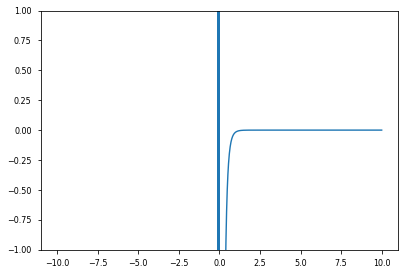

In [3]:
det_WB = lambda s: -12.8*19.4/(16.7*s+1.)/(14.4*s+1.)*np.exp(-4.*s) + 6.6*18.9 / (21.0*s+1) / (10.9*s+1)* np.exp(-11.*s)
det_WB = np.vectorize(det_WB)

plt.clf()
plt.plot(np.arange(-10,10,0.01), det_WB(np.arange(-10,10,0.01)))
plt.ylim([-1,1])
plt.show()

## Static Decoupling

Use the static decoupler for the system;

Compute the sum of two FOPTD within the approximations and the external time delay

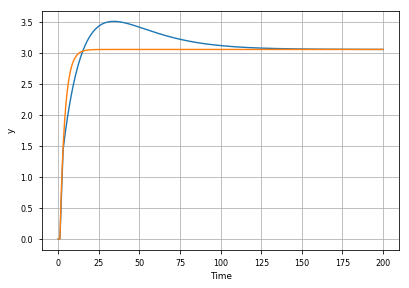

3.0546875000000036 2.98179028133 1.0


(0.20717021289440479, 2.5868537602910817, 0.080085784544346755)

In [4]:
# Approximate the first sum of Wood Berry
k,t,l = fotdsum(12.8,-18.9/12.8*6.6,16.7,21.0,1.0,3.0)
# Plot the approximation and the sum
y1,time = fotd(12.8,16.7,1.,np.arange(0,200,0.1))
y2,time = fotd(-18.9/12.8*6.6,21.,3.,time)
yA,time = fotd(k,t,l,time)

# Plot the systems
plt.clf()
plt.plot(time,y1+y2)
plt.plot(time, yA)
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('y')
plt.show()

# Calculate the IE,IAE and montonicity
mon = monotonicity(y1+y2,time)
# Print Parameter
print(k,t,l)
AMIGO(k,t,l)

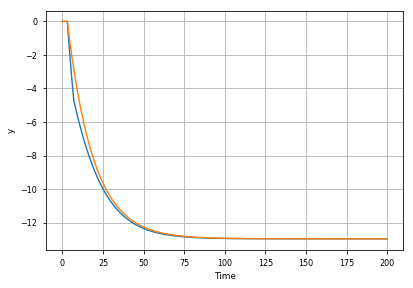

-12.970103092783503 16.1351164454 3.0


(-0.10188122335533614, 12.279006845128794, -0.0082971876015977171)

In [5]:
# Approximate the second sum of Wood Berry
k,t,l = fotdsum(-19.4,6.6/19.4*18.9,14.4,10.9,3.,7.)
# Plot the approximation and the sum
y1,time = fotd(-19.4,14.4,3.0,np.arange(0,200,0.1))
y2,time = fotd(6.6/19.4*18.9,10.9,7.0,time)
yA,time = fotd(k,t,l,time)

# Plot the systems
plt.clf()
plt.plot(time,y1+y2)
plt.plot(time, yA)
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('y')
plt.show()

# Print Parameter
print(k,t,l)
AMIGO(k,t,l)

## Dynamic Simple Decoupling

Approximate the SOPTD systems

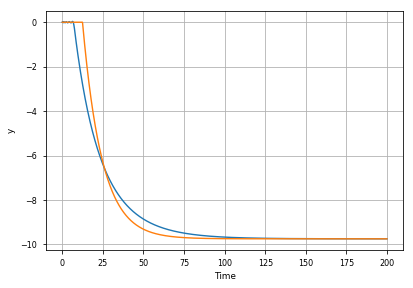

(-9.745312499999997, 12.049999999999999, 12.449999999999999)

In [25]:
# Approximate the trasnfer function model
k,t,l = dt2ptd2foptd(-18.9/12.8*6.6,21.,10.9,7.0,14.4)
# Exact model
tf = -18.9/12.8*6.6*cn.tf([14.4,1],[21.0*10.9,21.0+10.9,1])
num, den = cn.pade(7,10)
tf = tf*cn.tf(num,den)
y, time = cn.step(tf,np.arange(0,200,0.1))
yM, time = fotd(k,t,l, time)
# Plot the systems
plt.clf()
plt.plot(time,y)
plt.plot(time, yM)
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('y')
plt.show()
k,t,l

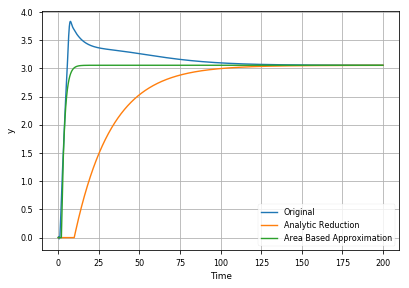

3.0546875000000036 22.725 9.80980818414
3.05526470076 1.87358633487 1.92220176826


(0.081011252064185163, 1.8811556081959409, 0.043064620338280409)

In [26]:
# Approximate the FOPTD sum
k,t,l = fotdsum(k, 12.8, t, 16.7, l, 1.)
# Plot
y1, time = fotd(12.8, 16.7, 1., time)
y = y+y1
yM, time = fotd(k,t,l, time)

# Use of area based methods
# Use decap
yD = y[:np.argmax(y)]
tD = time[:np.argmax(y)]
kA = yD[-1]#print(np.argmax(y))
TAR = 1./kA*np.trapz(yD[-1]-yD,tD)
tA = 1./kA*np.exp(1)*(np.trapz(yD[np.where(time<TAR)], tD[np.where(time<TAR)]))
lA = np.max([TAR-tA,0.])
kA = np.mean(y[-5])
yA, time = fotd(kA,tA,lA,time)

plt.clf()
plt.plot(time,y, label = "Original")
#plt.plot(time,y1)
#plt.plot(time,y-y1)
plt.plot(time,yM, label = "Analytic Reduction")
plt.plot(time,yA, label = "Area Based Approximation")
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('y')
plt.legend(loc = "lower right")
plt.savefig('WoodBerry_Dynamic_Approx.png')
plt.show()

print(k,t,l)
print(kA,tA,lA)
AMIGO(kA,tA,lA)

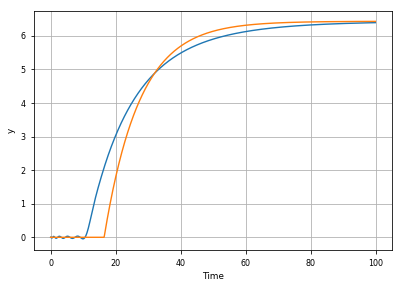

In [8]:
# Approximate the second transfer function model
k,t,l = dt2ptd2foptd(18.9/19.4*6.6,21.,10.9,11.,16.7)
# Plot the approximation and the sum
tf = 18.9/19.4*6.6*cn.tf([16.7,1],[21.0*10.9,21.0+10.9,1])
num, den = cn.pade(11,10)
tf = tf*cn.tf(num,den)
y, time = cn.step(tf,np.arange(0,100,0.1))
yM, time = fotd(k,t,l, time)
# Plot the systems
plt.clf()
plt.plot(time,y)
plt.plot(time, yM)
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('y')
plt.show()


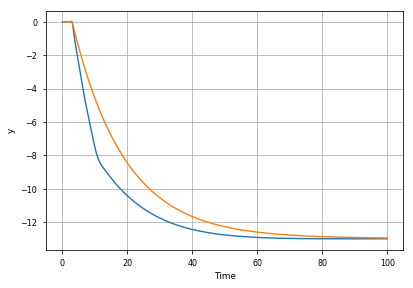

-12.970103092783503 16.1351164454 3.0


(-0.10188122335533614, 12.279006845128794, -0.0082971876015977171)

In [9]:
# Approximate the FOPTD sum
k,t,l = fotdsum(k, -19.4, t, 14.4, l, 3.)
# Plot
y1, time = fotd(-19.4, 14.4, 3., time)
y = y+y1
yM, time = fotd(k,t,l, time)
plt.clf()
plt.plot(time,y)
plt.plot(time,yM)
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('y')
plt.show()

print(k,t,l)
AMIGO(k,t,l)

# Rosenbrock
## Decentralized

In [7]:
# First and second controller
AMIGO(1.,1.,0.)

(2.823553719008264, 0.6076872246696036, 4.646393085757917)

## Simple Static Decoupling

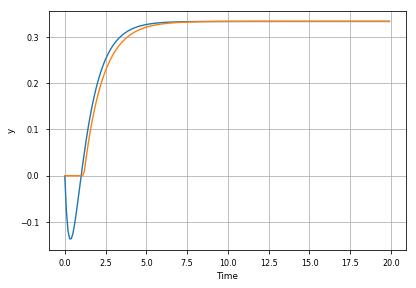

0.33333333333333337 1.16666666667 1.16666666667


(0.74999999999999978, 1.1666666666666667, 0.64285714285714257)

In [5]:
# Approximate the first function of Rosenbrock
k,t,l = fotdsum(1.,-2./3,1.,1./3.,0.,.0)
# Plot the approximation and the sum
y1,time = fotd(1.,1.,.0,np.arange(0,20,0.1))
y2,time = fotd(-2./3.,1./3.,0.,time)
yA,time = fotd(k,t,l,time)

# Plot the systems
plt.clf()
plt.plot(time,y1+y2)
plt.plot(time, yA)
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('y')
plt.show()

# Print Parameter
print(k,t,l)
AMIGO(k,t,l)

In [8]:
# Second AMIGO, transfer function is easy calculateable
AMIGO(1./3.,1.,0.)

(8.470661157024793, 0.6076872246696036, 13.939179257273754)

## Dynamic Simple Decoupling

In [10]:
# First and Second transferfunction
k,t,l = fotdsum(1,-2./3., 1., 1./3., 0., 0.)
print(k,t,l)
AMIGO(k,t,l)

0.33333333333333337 1.16666666667 1.16666666667


(0.74999999999999978, 1.1666666666666667, 0.64285714285714257)

# Experimental Data

In [3]:
# Model Structure: y = [Temp, Pres], u = [Fan, Valve]
G = lambda s : np.array([[-0.29/(10.*s+1)*np.exp(-1.*s), 0.625/(8.*s+1)*np.exp(-3.*s)],[-.5/(75.*s+1)*np.exp(-2.*s), -1.75/(20.*s+1)*np.exp(-2.0*s)]])
DetG = lambda s: np.linalg.det(G(s))
G = np.vectorize(G)
DetG = np.vectorize(DetG)
s = np.arange(-.5,10,0.001)

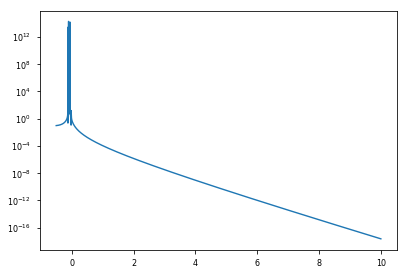

In [4]:
# Process has no RHP zeros ( numerical evaluation )
# All methods are possible

plt.clf()
plt.semilogy(s,np.abs(DetG(s)))
#plt.sem(s,np.zeros_like(s))
#plt.ylim([-.1,.1])
plt.show()

In [5]:
AMIGO(-0.29,10.,1.)

(-9.736392134511256, 6.076872246696035, -1.6022045123303166)

In [6]:
AMIGO(-1.75,20., 2.)

(-1.6134592680047222, 12.15374449339207, -0.13275408816451192)

## Simple Static

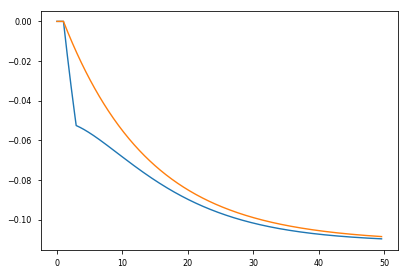

-0.11142857142857143 13.2051282051 1.0


(-25.339584657766469, 8.0245877103806631, -3.1577428738160598)

In [7]:
# Transfomed 11
time = np.arange(0.,50., 0.1)
y, time = fotd(-0.29, 10., 1., time) 
y, time  = y + fotd(0.5/1.75*0.625, 8., 3., time)
k,t,l = fotdsum(-0.29, 0.5/1.75*0.625, 10., 8.0, 1., 3.)
yM, time = fotd(k,t,l, time)
plt.clf()
plt.plot(time,y)
plt.plot(time,yM)
plt.show()
print(k,t,l)
AMIGO(k,t,l)

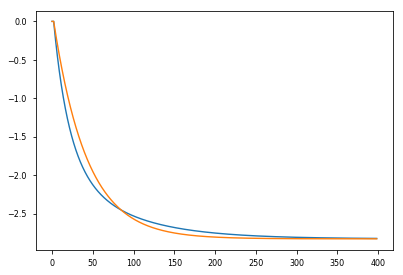

-2.8275862068965516 40.9603658537 2.0


(-0.99857387623463012, 24.891091047061348, -0.04011772221421054)

In [8]:
# Transfomed 2
time = np.arange(0.,400., 0.1)
y, time = fotd(-1.75, 20., 2., time) 
y, time  = y + fotd(-0.625/0.29*0.5, 75., 2., time)
k,t,l = fotdsum(-1.75, -0.625/0.29*0.5, 20., 75.0, 2., 2.)
yM, time = fotd(k,t,l, time)
plt.clf()
plt.plot(time,y)
plt.plot(time,yM)
plt.show()
print(k,t,l)
AMIGO(k,t,l)

## Dynamic

In [9]:
# First transfer function
kA,TA,LA = dt2ptd2foptd(-0.5/1.75*0.625,75.0,8.0,3.,20.)
k,t,l = fotdsum(-.29,kA,10.,TA,1.,LA)
print(k,t,l)
AMIGO(k,t,l)

-0.4685714285714285 28.6737804878 1.0


(-6.025876839346906, 17.424690085419574, -0.34582404678687328)

In [10]:
# Second transfer function
kA,TA,LA = dt2ptd2foptd(-0.625/0.29*1.75,20.,8.0,4.,10.)
k,t,l = fotdsum(-1.75,kA,20.,TA,2.,LA)
print(k,t,l)
AMIGO(k,t,l)

-5.5215517241379315 15.9016393443 2.0


(-0.38825107456512126, 10.623623866608684, -0.036546010988344632)

# Inverted

In [11]:
k11 = np.pi/(2.*3.*1.)
k22 = np.pi/(2.*3.*2.)
k11,k22

(0.5235987755982988, 0.2617993877991494)

In [12]:
# First controller
kp11 = k11 / -0.29
kp22 = k22 / -1.75
kd12 = 0.625 / k11
kd21 = -0.5 / k22
kp11,kp22, kd12, kd21

(-1.8055130193044788,
 -0.1495996501709425,
 1.1936620731892151,
 -1.9098593171027443)

# Multivariable PID

In [30]:
# Simplify the determinant to FOTD
# np.array([[-0.29/(10.*s+1)*np.exp(-1.*s), 0.625/(8.*s+1)*np.exp(-3.*s)],[-.5/(75.*s+1)*np.exp(-2.*s), -1.75/(20.*s+1)*np.exp(-2.0*s)]])
fotdsum(0.29*1.75,0.625*0.5, 30., )

(0.82, 71.8375, 3.0)

In [15]:
# FOTD Sum
k,t,l = fotdsum(k1,-k2,t1,t2,l1,l2)
k,t,l

(0.82, 45.579268292682933, -1.0)

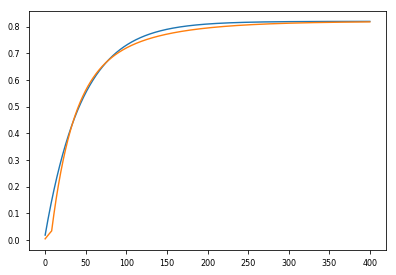

In [19]:
time = np.arange(0.,400.,0.1)
y1, time = fotd(k1,t1,l1,time)
y2, time = fotd(-k2, t2,l2, time)
y, time = fotd(k,t,l, time)
plt.clf()
plt.plot(time, y)
plt.plot(time, y1+y2)
plt.show()

In [28]:
# Compute the dt...approx for the controller
k,t,l = dt2ptd2foptd(-1.75/0.82,20.,0.,1.,45.)
k,t,l

(-2.1341463414634148, 20.0, 1.0)

In [ ]:
k,t,l = dt2ptd2foptd()